# Redes Neuronales NLP

In [1]:
import pandas as pd
import sklearn as sklearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [38]:
import os



df=pd.read_excel(
      "/content/drive/MyDrive/Colab Notebooks/reclamos_20201221_con_clas.xlsx",
     engine='openpyxl',
)

In [39]:
df.columns

Index(['CASO_ID', 'MERCADO_ANALISTA', 'DESCRIPCION_CIUDADANO',
       'PETICION_CIUDADANO'],
      dtype='object')

In [40]:
df['MERCADO_ANALISTA']=df['MERCADO_ANALISTA'].astype('category')

In [41]:
df=df[['MERCADO_ANALISTA','PETICION_CIUDADANO','DESCRIPCION_CIUDADANO']].dropna()

In [42]:
df['DESCRIPCION_CIUDADANO']=df['DESCRIPCION_CIUDADANO'].map(str).str.lower()
df['PETICION_CIUDADANO']=df['PETICION_CIUDADANO'].map(str).str.lower() 

In [43]:
df['data'] = df['DESCRIPCION_CIUDADANO'] + df['PETICION_CIUDADANO']

In [44]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['data'].apply(remove_punct)

In [45]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords

stop_words=stopwords.words('spanish')
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stop_words]
    
    return ' '.join(a_lemmas)
  
# Apply preprocess to ted['transcript']
df['data'] = df['data'].apply(preprocess)
print(df['data'] )

0      recibi correo electronico indica zurich santan...
1      nombre xx día enero año entregue carta anulaci...
2      estimados señore svs fecha octubre di baja seg...
3      primera instancia solicité renvar tarjeta cta ...
4      reclamo scotiabank cobros mantención productos...
                             ...                        
994    estimados favor revisar proceso fusión itau co...
995    fecha febrero protestados cheque cuales rescat...
996    mal calculo valor póliza ahorro error tipo cam...
997    estimados svs fecha anulado orden venta ejecut...
998    traspaso dos mil quinientas acciones compañía ...
Name: data, Length: 999, dtype: object


In [48]:
import unicodedata

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT', 'COMBINING TILDE')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

df['data'] = df['data'].apply(strip_accents)
print(df['data'] )

0      recibi correo electronico indica zurich santan...
1      nombre xx dia enero ano entregue carta anulaci...
2      estimados senore svs fecha octubre di baja seg...
3      primera instancia solicite renvar tarjeta cta ...
4      reclamo scotiabank cobros mantencion productos...
                             ...                        
994    estimados favor revisar proceso fusion itau co...
995    fecha febrero protestados cheque cuales rescat...
996    mal calculo valor poliza ahorro error tipo cam...
997    estimados svs fecha anulado orden venta ejecut...
998    traspaso dos mil quinientas acciones compania ...
Name: data, Length: 999, dtype: object


In [49]:
labels=(df['MERCADO_ANALISTA']=='Reclamo Valores').astype(int)

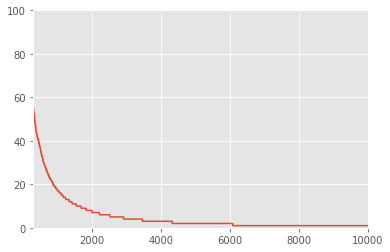

In [93]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1900)
tokenizer.fit_on_texts(df['data'].values)

input_array = tokenizer.texts_to_sequences(df['data'].values)

vocab_size = len(tokenizer.word_index) + 1  

wc=tokenizer.word_counts
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [94]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

input_array = pad_sequences(input_array, padding='post', maxlen=maxlen)

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_array, labels, test_size=0.2)

In [53]:
y_train

236    0
572    0
190    0
186    0
49     0
      ..
604    0
917    1
977    1
511    1
418    0
Name: MERCADO_ANALISTA, Length: 799, dtype: int64

# Red Neuronal Recurrente

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 7

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 7)            80528     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 7)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                128       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 80,673
Trainable params: 80,673
Non-trainable params: 0
_________________________________________________________________


El modelo recurrente tiende a decrecer la performance. Una alternativa es utilizar embeddings pre-entranados

https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout


embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          688600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 730,905
Trainable params: 730,905
Non-trainable params: 0
_________________________________________________________________


In [97]:
batch_size = 32
history=model.fit(X_train,y_train.values,epochs=100,batch_size=batch_size,validation_data=(X_test, y_test.values),verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 11ms/step - loss: 0.6891 - accuracy: 0.6204 - val_loss: 0.6755 - val_accuracy: 0.7000
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.6470 - val_loss: 0.6590 - val_accuracy: 0.7000
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6548 - val_loss: 0.6373 - val_accuracy: 0.7000
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6429 - accuracy: 0.6431 - val_loss: 0.6125 - val_accuracy: 0.7000
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6137 - accuracy: 0.6620 - val_loss: 0.5845 - val_accuracy: 0.7000
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.6582 - val_loss: 0.5529 - val_accuracy: 0.7050
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5421 - accuracy: 0.6962 - val_loss: 0.5166 - val_accuracy: 0.7250
Epoch 8/100


In [98]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validacion')
    plt.title('Exactitud')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validacion')
    plt.title('Objetivo')
    plt.legend()

Exactitud Entrenamiento: 1.0000
Exactitud Testing:  0.9150


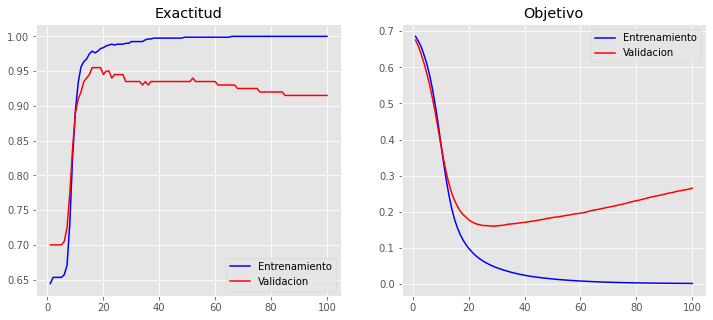

In [99]:
loss, accuracy = model.evaluate(X_train, y_train.values, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test.values, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test.values, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       133
           1       0.98      0.90      0.94        67

    accuracy                           0.96       200
   macro avg       0.97      0.94      0.95       200
weighted avg       0.96      0.96      0.96       200



In [ ]:
model.save('corfo_embedding.h5')

In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(1,n_error+1,2):
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    for j in range(2):
        if(i+j<n_error):
            bar=ax[j].bar(str_labels, err_pred[i+j], color='red')
            bar[int(true_label.iloc[i])].set_color('green')
            ax[j].set_title(str_labels[int(true_label.iloc[i+j])])
            ax[j].set_ylim([0, 1])
            ax[j].set_ylabel('Probabilidad')
plt.show()

# Red Neuronal Recurrente Probabilista

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 100

tfd = tfp.distributions
tfpl = tfp.layers

divergence_fn = lambda q , p , _ : tfd.kl_divergence(q,p)/X_train.shape[0]

def prior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    prior_model=Sequential([
        tfpl.DistributionLambda(
        lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n)))
    ])
    return prior_model


def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    posterior_model=Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

model = Sequential([
    Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen),
    GlobalMaxPool1D(),
    tfpl.DenseVariational(units=64,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentBernoulli.params_size(1),
                          activation=None,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentBernoulli(1)
])
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          688600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 64)                20901344  
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 2210      
_________________________________________________________________
independent_bernoulli (Indep ((None, 1), (None, 1))    0         
Total params: 21,592,154
Trainable params: 21,592,154
Non-trainable params: 0
_________________________________________________________________


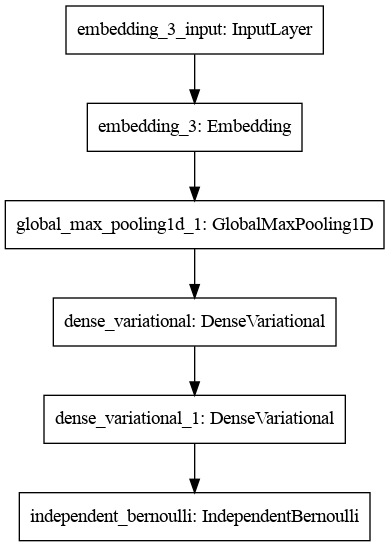

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file="variational_embedding.png",dpi=96)

In [ ]:
from tensorflow.keras.optimizers import RMSprop,Adam

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer='adam',
              loss=nll,
              metrics=['accuracy'])

In [ ]:
batch_size =32
history=model.fit(X_train,y_train,epochs=100,batch_size=batch_size,validation_data=(X_test, y_test),verbose=0)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False,batch_size=16)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False,batch_size=16)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       125
           1       0.42      0.64      0.51        75

    accuracy                           0.53       200
   macro avg       0.55      0.55      0.53       200
weighted avg       0.58      0.53      0.53       200



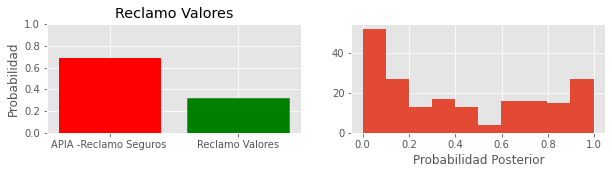

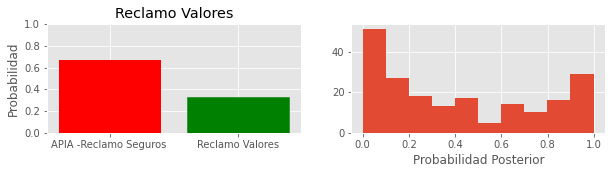

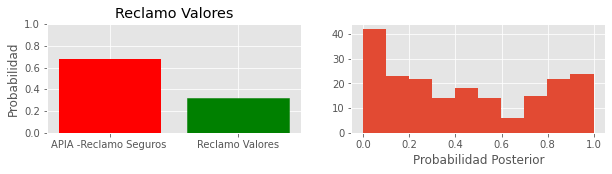

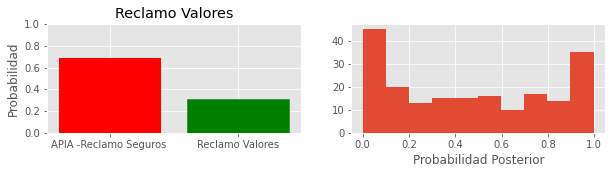

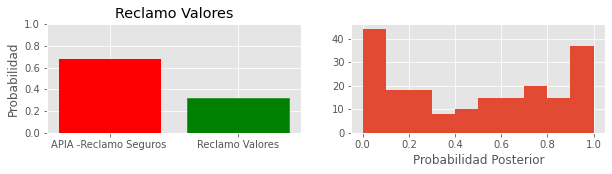

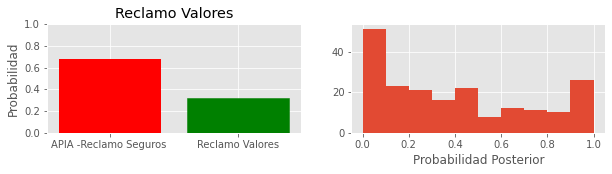

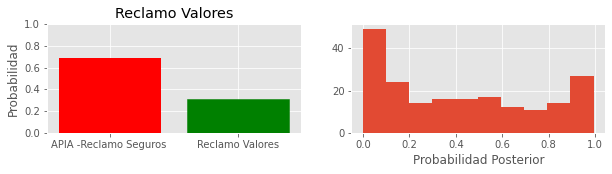

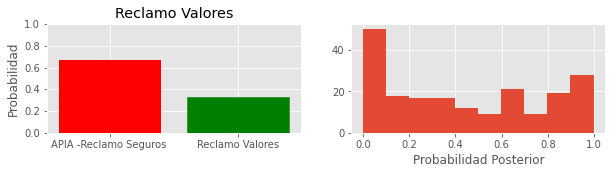

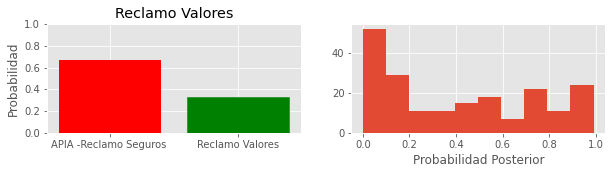

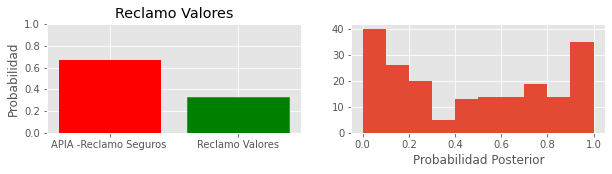

In [ ]:
y_pred=model(X_test).mean().numpy()
class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
X_error=X_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(10):
    predicted_probabilities=[]
    for _ in range(200):
        predicted_probabilities.append(model(X_error[i][np.newaxis, ...]).mean().numpy()[0])
    predicted_probabilities=np.stack(predicted_probabilities).flatten()
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    bar=ax[0].bar(str_labels, err_pred[i], color='red')
    bar[int(true_label.iloc[i])].set_color('green')
    ax[0].set_title(str_labels[int(true_label.iloc[i+j])])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('Probabilidad')
    ax[1].hist(predicted_probabilities)
    ax[1].set_xlabel('Probabilidad Posterior')
plt.show()

# Embeddings Pre-entrenados

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '/content/drive/MyDrive/Colab Notebooks/data/glove-sbwc.i25.vec'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)